In [1]:
%pylab inline
from __future__ import division
import scipy as sp
from scipy import stats
import csv
from decimal import *
import mpld3
mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# from operator import mul    # or mul=lambda x,y:x*y
# from fractions import Fraction

import operator as op
def nCr(n, r):
    r = min(r, n-r)
    if r == 0: return 1
    numer = reduce(op.mul, xrange(n, n-r, -1))
    denom = reduce(op.mul, xrange(1, r+1))
    return numer//denom

# def nCr(n,r): 
#   return int( reduce(mul, (Fraction(n-i, i+1) for i in range(r)), 1) )

# def nCr(n,r):
#     f = math.factorial
#     return f(n) / f(r) / f(n-r)

# Use python round
# def round(x, n):
#     return int(np.rint(a * 10**n)) / 10.**n

In [3]:
# 4,3 Hamming Code - Reed Solomon Wrap
def hs_rs_table(rate, blocklength):
    k = (1-rate)*blocklength
    msg = rate*blocklength
#     res = {}
    op_SNR = arange(0, 5, 0.01)
    pbitdrop = array([0.5*math.erfc(sqrt(10**opsnr/2)) for opsnr in op_SNR])
#     op_SNR = 1
#     while op_SNR < 10**(5): # 10 = 100 dB
#         pbitdrop = 0.5*math.erfc(sqrt(op_SNR/2))
    hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
    hcflst = 1 - (1-hcerr)**2
#     for idx in range(len(hcf)):
    reeddrop = [sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)]) \
                for hcf in hcflst]
#         res[op_SNR[idx]] = reeddrop
#         op_SNR *= 10**(0.01)
    res = dict(zip(op_SNR, reeddrop))
    return res
    
def print_table_csv(table, filename):
    ks = sorted(table.keys())
    vs = [table[k] for k in ks]
    with open(filename+'.csv', 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['SNR (dB)', 'P(fail)'])
        for rowid in xrange(len(ks)):
            writer.writerow([str(ks[rowid]),str(vs[rowid])])
#             writer.writerow([str(log10(ks[rowid])),str(vs[rowid])])
            

In [19]:
%%time
# Table Generation
test = hs_rs_table(4/7, 256)
print_table_csv(test, 'testnew')

CPU times: user 3.14 s, sys: 22.8 ms, total: 3.16 s
Wall time: 3.46 s


In [71]:
# 4,3 Hamming Code - Reed Solomon Wrap
def hs_rs_table(rate, blocklength):
    k = (1-rate)*blocklength
    msg = rate*blocklength
    res = {}
    op_SNR = 1
    while log10(op_SNR) <= 5.0: # 10 = 100 dB
        pbitdrop = 0.5*math.erfc(sqrt(op_SNR/2))
        hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
        hcf = 1 - (1-hcerr)**2
        reeddrop = sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)])
        res[op_SNR] = reeddrop
        op_SNR *= 10**(0.1)
    return res
    
def print_table_csv(table, filename):
    ks = sorted(table.keys())
    vs = [table[k] for k in ks]
    with open(filename+'.csv', 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['SNR (dB)', 'P(fail)'])
        for rowid in xrange(len(ks)):
            writer.writerow([str(log10(ks[rowid])),str(vs[rowid])])
            

In [72]:
num_nodes = arange(1, 36, 1)
# rates = num_nodes * 160/1000
for n in num_nodes:
    filename = 'lookup_0-1/n' + str(n)
    rate = n*160/10000
    print_table_csv(hs_rs_table(rate, 256), filename)

In [3]:
def load_table(filename):
    codetable = {}
    with open(filename, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if row[0] == 'SNR (dB)':
                continue
            codetable[Decimal(row[0])] = float(row[1])
    return codetable

def load_ordered_table(filename):
    codetable = []
    with open(filename, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if row[0] == 'SNR (dB)':
                continue
            codetable.append((float(row[0]), float(row[1])))
    return codetable

In [4]:
def lookup(codetable, kmin, kmax, snr):
    if snr < kmin: return 1.0
    elif snr > kmax: return 0.0
    return codetable[snr]

def snr_lookup(codetable, kmin, kmax, opSNR, dSNR):
    op_SNR = Decimal(str(opSNR))
    if op_SNR < kmin: return 1.0
    elif op_SNR > kmax: return 0.0
    if op_SNR in codetable:
        return codetable[op_SNR]
    lsnr = op_SNR - op_SNR % Decimal(str(dSNR))
    rsnr = op_SNR + Decimal(str(dSNR)) - op_SNR % Decimal(str(dSNR))
#     lsnr = op_SNR.quantize(Decimal(str(dSNR)), rounding=ROUND_DOWN)
#     rsnr = op_SNR.quantize(Decimal(str(dSNR)), rounding=ROUND_UP)
    lp, rp = lookup(codetable, kmin, kmax, lsnr), lookup(codetable, kmin, kmax, rsnr)
    return (rp-lp)*(opSNR-float(lsnr))/dSNR + lp

In [9]:
def p_single(codetable, kmin, kmax, op_SNR, endpoint, dfade, tabledSNR):
    fadexp = sp.stats.expon()
    fade = arange(0, endpoint, dfade)
    return dfade*sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) for f in fade])

In [16]:
# Changing bin width
def p_single(codetable, kmin, kmax, op_SNR, endpoint, dfade, tabledSNR):
    fadexp = sp.stats.expon()
    psingle = []
    fade = arange(0, endpoint[0], dfade[0])
    psingle.append(dfade[0]*sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) for f in fade]))
    for idx in range(1, len(endpoint)):
        fade = arange(endpoint[idx-1], endpoint[idx], dfade[idx])
        psingle.append(dfade[idx]*sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) for f in fade]))
    return sum(psingle)

In [12]:
# Inner product
def p_single(codetable, kmin, kmax, op_SNR, endpoint, dfade, tabledSNR):
    fadexp = sp.stats.expon()
    psingle = []
    fade = arange(0, endpoint[0], dfade[0])
    snrlookup = array([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) for f in fade])
    fadepr = fadexp.pdf(fade)
    psingle.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpoint)):
        fade = arange(endpoint[idx-1], endpoint[idx], dfade[idx])
        snrlookup = array([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) for f in fade])
        fadepr = fadexp.pdf(fade)
        psingle.append(dfade[idx]*np.dot(snrlookup, fadepr))
    return sum(psingle)

In [10]:
def p_combo(codetable, kmin, kmax, a, op_SNR, endpoint, dfade, tabledSNR):
    if a == 0:
        return 1.0
    fadexp = sp.stats.erlang(a)
    # 0.01 = dSNR for 4,3 Hamming Code table
    fade = arange(0, endpoint, dfade)
    return sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) * dfade for f in fade])

In [26]:
# Changing bins
def p_combo(codetable, kmin, kmax, a, op_SNR, endpoint, dfade, tabledSNR):
    if a == 0:
        return 1.0
    fadexp = sp.stats.erlang(a)
    pcombo = []
    fade = arange(0, endpoint[0], dfade[0])
    pcombo.append(sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) * dfade[0] for f in fade]))
    for idx in range(1, len(endpoint)):
        fade = arange(endpoint[idx-1], endpoint[idx], dfade[idx])
        pcombo.append(sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) * dfade[idx] for f in fade]))
    return sum(pcombo)

In [11]:
# N = num_nodes
def p_protocol(codetable, kmin, kmax, N, op_SNR, endpoint, dfade, tabledSNR):
    psingle = p_single(codetable, kmin, kmax, op_SNR, endpoint, dfade, tabledSNR)
#     print('psingle', psingle, 'pcombo, ')
    return sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * (1-(1-p_combo(codetable, kmin, kmax, a, op_SNR, endpoint, dfade, tabledSNR))**(N-a)) for a in range(N)])

In [7]:
codetable = load_table('testorig.csv')

In [10]:
singles = []

In [8]:
%%time
dSNR, dfade, end = 0.01, 0.01, 2
SNRdB = arange(0, log10(10**5/50), 0.01)
# SNR_lst = 10**x
y = [p_single(codetable, 0.0, 5.0, SNR, end, dfade, dSNR) for SNR in SNRdB]
plot(10*SNRdB, y, lw=2.0)
title('P(single fail)', fontsize=24)
xlabel('Operating SNR (dB)', fontsize=20)

singles.append((10*SNRdB, y))

TypeError: 'int' object has no attribute '__getitem__'

CPU times: user 16.4 s, sys: 182 ms, total: 16.5 s
Wall time: 17.2 s


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


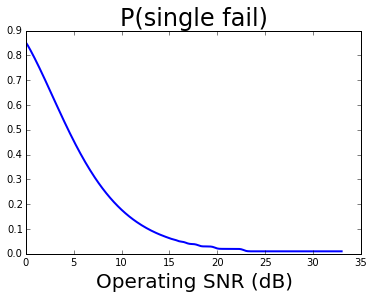

In [13]:
%%time
dSNR, dfade, end = 0.01, [0.01, 0.01], [1, 2]
# Two bins, same dfade
SNRdB = arange(0, log10(10**5/50), 0.01)
# SNR_lst = 10**x
y = [p_single(codetable, 0.0, 5.0, SNR, end, dfade, dSNR) for SNR in SNRdB]
plot(10*SNRdB, y, lw=2.0)
title('P(single fail)', fontsize=24)
xlabel('Operating SNR (dB)', fontsize=20)

singles.append((10*SNRdB, y))

CPU times: user 11.8 s, sys: 76.6 ms, total: 11.9 s
Wall time: 12 s


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


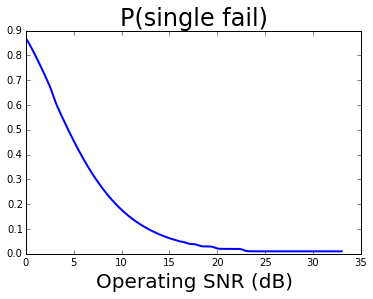

In [18]:
%%time
dSNR, dfade, end = 0.01, [0.01, 0.1], [1, 2]
# dfade 0.01, 0.1
SNRdB = arange(0, log10(10**5/50), 0.01)
# SNR_lst = 10**x
y = [p_single(codetable, 0.0, 5.0, SNR, end, dfade, dSNR) for SNR in SNRdB]
plot(10*SNRdB, y, lw=2.0)
title('P(single fail)', fontsize=24)
xlabel('Operating SNR (dB)', fontsize=20)

singles.append((10*SNRdB, y))

CPU times: user 1min 54s, sys: 511 ms, total: 1min 55s
Wall time: 1min 56s


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


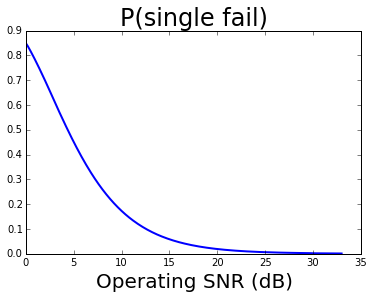

In [19]:
%%time
dSNR, dfade, end = 0.01, [0.001, 0.01], [1, 2]
# dfade 0.001, 0.01
SNRdB = arange(0, log10(10**5/50), 0.01)
# SNR_lst = 10**x
y = [p_single(codetable, 0.0, 5.0, SNR, end, dfade, dSNR) for SNR in SNRdB]
plot(10*SNRdB, y, lw=2.0)
title('P(single fail)', fontsize=24)
xlabel('Operating SNR (dB)', fontsize=20)

singles.append((10*SNRdB, y))

CPU times: user 17min 54s, sys: 6.53 s, total: 18min
Wall time: 18min 23s


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


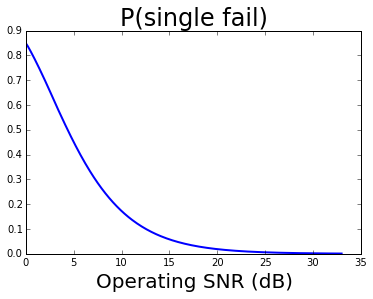

In [22]:
%%time
dSNR, dfade, end = 0.01, [10**(-4), 0.01], [1, 2]
# dfade 0.001, 0.01
SNRdB = arange(0, log10(10**5/50), 0.01)
# SNR_lst = 10**x
y = [p_single(codetable, 0.0, 5.0, SNR, end, dfade, dSNR) for SNR in SNRdB]
plot(10*SNRdB, y, lw=2.0)
title('P(single fail)', fontsize=24)
xlabel('Operating SNR (dB)', fontsize=20)

singles.append((10*SNRdB, y))

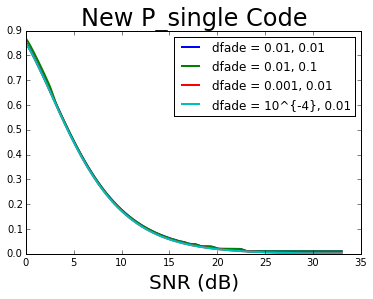

In [24]:
x = 10*SNRdB
# plot(x, singles[0][1], lw=2.0, label='dfade = 0.01')
plot(x, singles[1][1], lw=2.0, label='dfade = 0.01, 0.01')
plot(x, singles[2][1], lw=2.0, label='dfade = 0.01, 0.1')
plot(x, singles[3][1], lw=2.0, label='dfade = 0.001, 0.01')
plot(x, singles[4][1], lw=2.0, label='dfade = 10^{-4}, 0.01')
legend(loc=0)
title('New P_single Code', fontsize=24)
xlabel('SNR (dB)', fontsize=20)
# savefig('psingle_binwidth.pdf', bbox='tight')

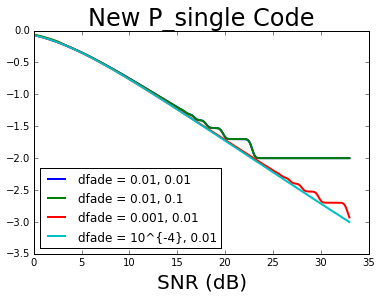

In [30]:
x = 10*SNRdB
# plot(x, singles[0][1], lw=2.0, label='dfade = 0.01')
plot(x, log10(singles[1][1]), lw=2.0, label='dfade = 0.01, 0.01')
plot(x, log10(singles[2][1]), lw=2.0, label='dfade = 0.01, 0.1')
plot(x, log10(singles[3][1]), lw=2.0, label='dfade = 0.001, 0.01')
plot(x, log10(singles[4][1]), lw=2.0, label='dfade = 10^{-4}, 0.01')
legend(loc=0)
title('New P_single Code', fontsize=24)
xlabel('SNR (dB)', fontsize=20)
savefig('psingle_binwidth_log.pdf', bbox='tight')

In [25]:
resid = max(abs(array(singles[3][1]) - array(singles[4][1])))
print(resid)

0.000798382959987


In [41]:
combos = []

CPU times: user 4min 5s, sys: 1.72 s, total: 4min 6s
Wall time: 4min 31s


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


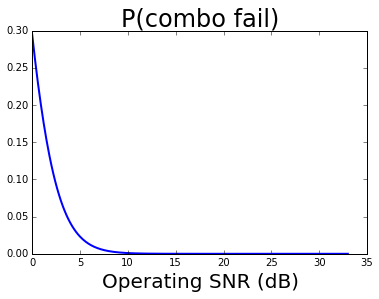

In [43]:
%%time
dSNR, dfade, end = 0.01, 0.005, 10
a = 3
SNRdB = arange(0, log10(10**5/50), 0.01)
# SNR_lst = 10**x
y = [p_combo(codetable, 0.0, 5.0, a, SNR, end, dfade, dSNR) for SNR in SNRdB]
plot(10*SNRdB, y, lw=2.0)
title('P(combo fail)', fontsize=24)
xlabel('Operating SNR (dB)', fontsize=20)

combos.append((10*SNRdB, y))

In [46]:
protocol = []

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


CPU times: user 3min 10s, sys: 1.51 s, total: 3min 12s
Wall time: 14h 38min 43s


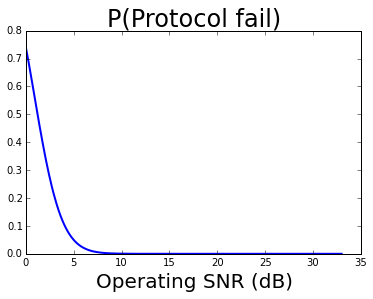

In [28]:
%%time
dSNR, dfade, end = 0.01, [0.005, 0.01], [1, 2]
N = 5
codetable = load_table('lookup_tables/n5.csv') # table resolution 0.01dB
SNRdB = arange(0, log10(10**5/50), 0.01)
# SNR_lst = 10**x
y = [p_protocol(codetable, 0.0, 5.0, N, SNR, end, dfade, dSNR) for SNR in SNRdB]
plot(10*SNRdB, y, lw=2.0)
title('P(Protocol fail)', fontsize=24)
xlabel('Operating SNR (dB)', fontsize=20)

# protocol.append((10*SNRdB, y))

CPU times: user 21min 28s, sys: 8.28 s, total: 21min 37s
Wall time: 23min 40s


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


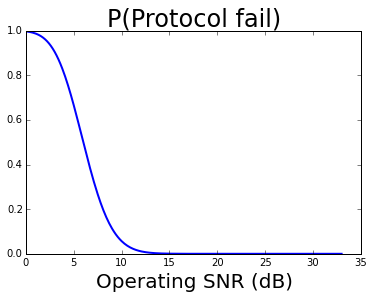

In [86]:
%%time
dSNR, dfade, end = 1, 0.005, 10
N = 5
codetable = load_table('lookup_1/n5.csv') # table resolution 0.01dB
tablemin, tablemax = min(codetable), max(codetable)
SNRdB = arange(0, log10(10**5/50), 0.01)
# SNR_lst = 10**x
y = [p_protocol(codetable, tablemin, tablemax, N, SNR, end, dfade, dSNR) for SNR in SNRdB]
plot(10*SNRdB, y, lw=2.0)
title('P(Protocol fail)', fontsize=24)
xlabel('Operating SNR (dB)', fontsize=20)

protocol.append((10*SNRdB, y))

CPU times: user 21min 27s, sys: 8.68 s, total: 21min 35s
Wall time: 23min 16s


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


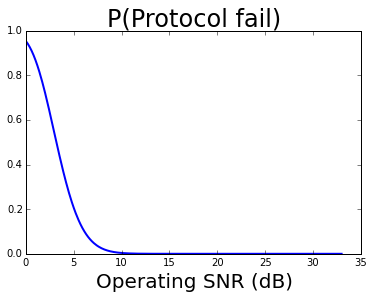

In [87]:
%%time
dSNR, dfade, end = 0.5, 0.005, 10
N = 5
codetable = load_table('lookup_0-5/n5.csv') # table resolution 0.01dB
tablemin, tablemax = min(codetable), max(codetable)
SNRdB = arange(0, log10(10**5/50), 0.01)
# SNR_lst = 10**x
y = [p_protocol(codetable, tablemin, tablemax, N, SNR, end, dfade, dSNR) for SNR in SNRdB]
plot(10*SNRdB, y, lw=2.0)
title('P(Protocol fail)', fontsize=24)
xlabel('Operating SNR (dB)', fontsize=20)

protocol.append((10*SNRdB, y))

CPU times: user 22min 59s, sys: 9.72 s, total: 23min 9s
Wall time: 24min 47s


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


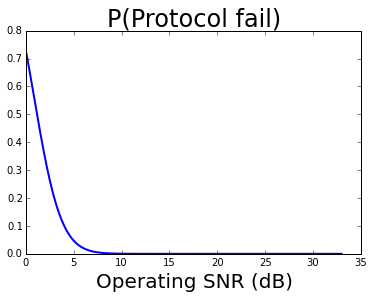

In [88]:
%%time
dSNR, dfade, end = 0.1, 0.005, 10
N = 5
codetable = load_table('lookup_0-1/n5.csv') # table resolution 0.01dB
tablemin, tablemax = min(codetable), max(codetable)
SNRdB = arange(0, log10(10**5/50), 0.01)
# SNR_lst = 10**x
y = [p_protocol(codetable, tablemin, tablemax, N, SNR, end, dfade, dSNR) for SNR in SNRdB]
plot(10*SNRdB, y, lw=2.0)
title('P(Protocol fail)', fontsize=24)
xlabel('Operating SNR (dB)', fontsize=20)

protocol.append((10*SNRdB, y))

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


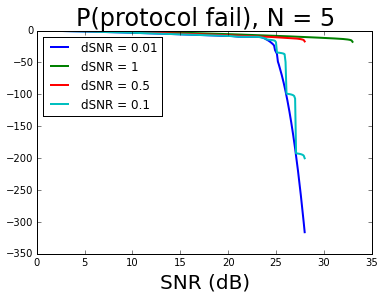

In [96]:
x = 10*SNRdB
plot(x, log10(protocol[0][1]), lw=2.0, label='dSNR = 0.01')
plot(x, log10(protocol[1][1]), lw=2.0, label='dSNR = 1')
plot(x, log10(protocol[2][1]), lw=2.0, label='dSNR = 0.5')
plot(x, log10(protocol[3][1]), lw=2.0, label='dSNR = 0.1')
legend(loc=0)
title('P(protocol fail), N = 5', fontsize=24)
xlabel('SNR (dB)', fontsize=20)
savefig('dSNR_residual_n5.pdf', bbox='tight')

In [91]:
error1 = max(abs(array(protocol[1][1]) - array(protocol[0][1])))
error0_5 = max(abs(array(protocol[2][1]) - array(protocol[0][1])))
error0_1 = max(abs(array(protocol[3][1]) - array(protocol[0][1])))
print(error1)
print(error0_5)
print(error0_1)

0.718637870033
0.376566228518
0.00290799770307


CPU times: user 35.5 s, sys: 219 ms, total: 35.7 s
Wall time: 36.3 s


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


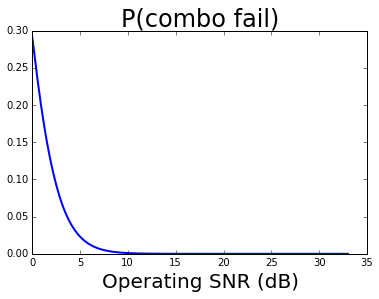

In [27]:
%%time
dSNR, dfade, end = 0.01, [0.005, 0.01], [1, 2]
a = 3
SNRdB = arange(0, log10(10**5/50), 0.01)
# SNR_lst = 10**x
y = [p_combo(codetable, 0.0, 5.0, a, SNR, end, dfade, dSNR) for SNR in SNRdB]
plot(10*SNRdB, y, lw=2.0)
title('P(combo fail)', fontsize=24)
xlabel('Operating SNR (dB)', fontsize=20)